# Graph Tool Sanbox

In [6]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt
import networkx as nx
from Functions import *
from Segregation import *

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from forceatlas2 import forceatlas2_networkx_layout

# Miscellaneous
from glob import glob
from tqdm import tqdm
import random

Grafo Minimo reproducible similar al grafo grande

This is our toy edge list [(0, 1), (1, 2), (2, 0), (3, 1), (4, 5)]
This are our toy weights [8, 9, 7, 10, 12, 11]


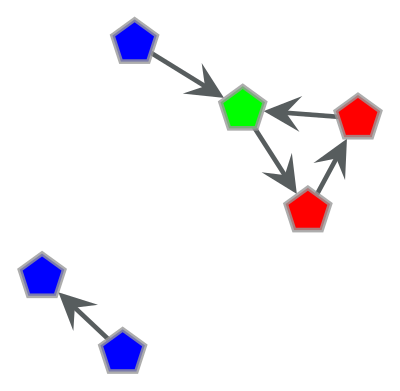

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa5d841a650, at 0x7fa60053b250>

In [9]:
# TOY GRAPH FOR CALCULATIONS
random.seed(1)

edge_list = [(0,1),(1,2),(2,0),(3,1),(4,5)] # ,(5,4) vovler a colocarlo
vertex_dict = {
    'label': 'a b c d e f'.split(' '),
    'pa': 'd c d i i i'.split(' '),
    'id': [i for i in range(10000,10006)]
}
color = {
    'i': (0,0,1), # Azul
    'd': (1,0,0), # Rojo
    'c': (0,1,0) # Centro
}
weights = [8,9,7,10,12,11]
g = gt.Graph(directed=True)
print(f'This is our toy edge list {edge_list}')
print(f'This are our toy weights {weights}')

g.add_edge_list(edge_list=edge_list)

# Create an edge property map for weights
edge_weight_map = g.new_edge_property("double")
edge_date_map = g.new_edge_property('string')

# Create a Vertex property map for labels
vertex_PA_map = g.new_vertex_property('string')
vertex_ID_map = g.new_vertex_property('int64_t')
vertex_color_map = g.new_vertex_property('vector<double>')
vertex_label_map = g.new_vertex_property('string')

# Add edges properties
edge_list = g.get_edges()
for i, e in enumerate(edge_list):
    edge_weight_map[e] = weights[i]
    edge_date_map[e] = '2021-05-16'

# Add Vertex properties
vertex_list = g.get_vertices()
for v in vertex_list:
    vertex_PA_map[v] = vertex_dict['pa'][v]
    vertex_ID_map[v] = vertex_dict['id'][v]
    vertex_label_map[v] = vertex_dict['label'][v]
    vertex_color_map[v] = color[vertex_dict['pa'][v]]

# Assign the maps to the Graph Object
g.vp['Political Label'] = vertex_PA_map
g.vp['User ID'] = vertex_ID_map
g.vp['Label'] = vertex_label_map
g.vp['Color'] = vertex_color_map
g.ep['Normal Weights'] = edge_weight_map
g.ep['Ending date'] = edge_date_map

# Create a graph layout and drawing
pos = gt.sfdp_layout(g)

gt.graph_draw(g,
              pos=pos,
              output_size=(200, 200),
              vertex_fill_color=vertex_color_map, # Uncomment to show Vertex colors
              #vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')

In [131]:
def fraction_graph(g,percentage, seed=437):
    random.seed(seed)
    # Get the total number of vertices and edges
    edge_list = list(g.iter_edges())
    vertex_list = list(g.iter_vertices())

    # Calculate the number of vertices and edges for the subgraph
    num_subgraph_vertices = int(len(vertex_list) * (percentage / 100))
    num_subgraph_edges = int(len(edge_list) * (percentage / 100))

    # Get random indices for vertices and edges
    selected_vertices = random.sample(vertex_list, num_subgraph_vertices)
    selected_edges = random.sample(edge_list, num_subgraph_edges)

    # Filter edges connected to nodes labeled type
    filtered_edges = g.new_edge_property("bool")
    filtered_edges.a = False

    # Filter nodes with label type
    filtered_nodes = g.new_vertex_property("bool")
    filtered_nodes.a = False
            
    for v in g.iter_vertices():
        if v in selected_vertices:
            vertex = g.vertex(v)
            filtered_nodes[vertex] = True
            for e in vertex.out_edges():
                edge_tuple = [int(e.source()), int(e.target())]
                if edge_tuple in selected_edges:
                    filtered_edges[e] = True

    subgraph = gt.GraphView(g,vfilt=filtered_nodes, efilt=filtered_edges)
    return subgraph

In [133]:
print(fraction_graph(g,90, seed=3))

[1, 4, 5, 3, 2] [[4, 5], [0, 1], [2, 0], [3, 1]]
<GraphView object, undirected, with 5 vertices and 2 edges, 5 internal vertex properties, 3 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fdf847289d0, at 0x7fdf84784cd0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fdf847289d0, at 0x7fdf84785050>, False), at 0x7fdf847289d0>


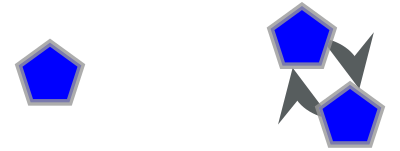

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe9a14ed690, at 0x7fe9a215c050>

In [41]:
subgraph = filter_graph(g,'i')

gt.graph_draw(subgraph,
              pos=pos,
              output_size=(200, 200),
              vertex_fill_color=vertex_color_map, # Uncomment to show Vertex colors
              #vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')

In [148]:
# FUNCTION TESTING
print('Adjacency Matrix')
print(get_adjacency(g,weight='Normal Weights'))
print('Nodes')
print(g.get_vertices())
print('Types Array')
print(get_types_array(g,types='Political Label'))
print('Types Dictionary')
print(get_types_dict(g,types='Political Label'))
print('Types Index Dictionary')
print(get_types_index(g,types='Political Label'))
print('Types Matrix (A column is one of the arrays in the Types Dictionary)')
print(get_types_matrix(g,types='Political Label'))
print('Contact Layer')
print(get_contact_layer(g,types='Political Label'))
print('Me Vs Others (Contact Layer cosidering one group Against all others) for Derecha')
print(me_vs_others(get_contact_layer(g,types='Political Label'), get_types_index(g,types='Political Label')['d'] ))

Adjacency Matrix
[[ 0.  8.  7.  0.  0.  0.]
 [ 8.  0.  9. 10.  0.  0.]
 [ 7.  9.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 12.]
 [ 0.  0.  0.  0. 12.  0.]]
Nodes
[0 1 2 3 4 5]
Types Array
['d' 'c' 'd' 'i' 'i' 'i']
Types Dictionary
{'c': [0, 1, 0, 0, 0, 0], 'd': [1, 0, 1, 0, 0, 0], 'i': [0, 0, 0, 1, 1, 1]}
Types Index Dictionary
{'c': 0, 'd': 1, 'i': 2}
Types Matrix (A column is one of the arrays in the Types Dictionary)
[[0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
Contact Layer
[[0. 2. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
Me Vs Others (Contact Layer cosidering one group Against all others) for Derecha
[[1. 0.]
 [2. 2.]]


In [10]:
def to_networkx(g: gt.Graph) -> nx.Graph:
    
    if g.is_directed():
        nx_graph = nx.DiGraph()
    else:
        nx_graph = nx.Graph()

    # Add nodes with their properties to the NetworkX graph
    for v in g.vertices():
        node_properties = {prop_name: g.vp[prop_name][v] for prop_name in g.vp}
        nx_graph.add_node(int(v), **node_properties)

    # Add edges with their properties to the NetworkX graph
    for e in g.edges():
        edge_properties = {prop_name: g.ep[prop_name][e] for prop_name in g.ep}
        nx_graph.add_edge(int(e.source()), int(e.target()), **edge_properties)
    
    return nx_graph

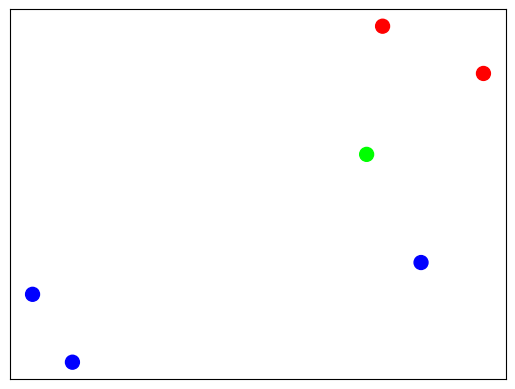

In [57]:
random.seed(2)
# Convert it to Network X
g_nx = to_networkx(g)

# Calculate aesthetics fo visualizatoin
colors = [node[1]['Color'] for node in g_nx.nodes(data=True)]
node_in_degree = [g_nx.in_degree(node) for node in g_nx.nodes]

# For Layout Algorythim, calculate it as undirected
g_nx_undir = g_nx.to_undirected()

# Generate random positions for the nodes
pos = {i: (random.random(), random.random()) for i in g_nx_undir.nodes}
pos[923] = (12,3)
pos[8917] = (23,1)
# Apply ForceAtlas2 layout algorithm
layout = forceatlas2_networkx_layout(g_nx_undir, pos, niter=50)

# Draw the network using matplotlib
nx.draw_networkx_nodes(g_nx_undir, layout, node_color=colors,
                                      node_size = 100)

# Display the plot
plt.show()

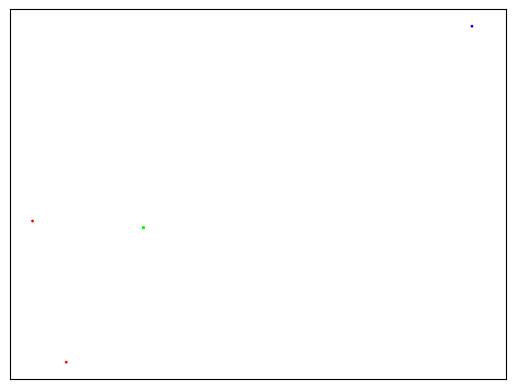

In [54]:
g_nx = to_networkx(g)
date = '2'
random.seed(4)
# Calculate aesthetics fo visualization
colors = [node[1]['Color'] for node in g_nx.nodes(data=True)]
node_in_degree = [g_nx.in_degree(node) for node in g_nx.nodes]

# For Layout Algorythim, calculate it as undirected
g_nx_undir = g_nx.to_undirected()
    
# Generate random positions for the nodes

# Apply ForceAtlas2 layout algorithm
layout = forceatlas2_networkx_layout(g_nx_undir, niter=50)

# Draw the network using matplotlib
nx.draw_networkx_nodes(g_nx_undir, layout, node_color=colors,
                                        node_size = node_in_degree)

# Display the plot
plt.savefig('viz.png')

In [58]:
pos

{0: (0.9560342718892494, 0.9478274870593494),
 1: (0.05655136772680869, 0.08487199515892163),
 2: (0.8354988781294496, 0.7359699890685233),
 3: (0.6697304014402209, 0.3081364575891442),
 4: (0.6059441656784624, 0.6068017336408379),
 5: (0.5812040171120031, 0.15838287025480557),
 923: (12, 3),
 8917: (23, 1)}

In [59]:
layout

{0: (0.5779965344123201, 4.818327409606928),
 1: (0.03940759086221892, 0.020260776501741688),
 2: (3.9835400717828997, 3.0491709054878617),
 3: (1.8764087395470492, -4.02870788546028),
 4: (-11.2391963643905, -5.218568200415148),
 5: (-9.892767129666385, -7.760039158043137)}